**Data Science and AI for Energy Systems** 

Karlsruhe Institute of Technology

Institute of Automation and Applied Informatics

Summer Term 2024

---

# Exercise V: Central Limit Theorem and Superstatistics

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
import seaborn as sns
from scipy.stats import levy_stable
from scipy.special import gamma

## Problem V.2 (programming) -- Stable distributions

**After examining some properties of Gaussian random variables, we want to take a look into non-Gaussian distributions, i.e. in the exercise we consider stable distributions. We start with writing a function for the probability density depending on the stability, skewness, scale and location parameters.**

***
**(a) The characteristic function $\varphi(t,\alpha, \beta, c, \mu)$ of a stable probability distribution is given by**


In [2]:
def char_fun_stable(t,alpha, beta, c, mu):
    return np.exp(1j*t*mu - ((np.abs(c*t))**(alpha))*
            (1-1j*beta*np.sign(t)*np.tan(np.pi*alpha/2)))

**for $\alpha \neq 1$.<br>
Now we can denote a formula for the probability density function (PDF) of the stable distribution. The PDF is given as a Fourier Transform of the characteristic function:
\begin{align*}p(x)=\frac{1}{2\pi}\int_{-\infty}^{+\infty}\varphi(t)e^{-ixt}dt.\end{align*} 
Write a function for the PDF using *scipy.integrate.quad*.**

In [3]:
def integrand(t,x,alpha,beta,c,mu):
    return char_fun_stable(t,alpha, beta, c, mu)*np.exp(-1j*x*t)
def p(x, alpha, beta, c, mu):
    # we use the scipy quad function to integrate the integrand, for details see the scipy documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html
    return (1/(2*np.pi)) * sc.integrate.quad(integrand,-np.inf,np.inf,args=(x,alpha,beta,c,mu))[0]

***
**(b) Consider the parameters $c = 1, \mu = 0$. Plot the PDF for each combination of $\alpha \in \{0.4,1.5\}$ and $\beta \in \{0,0.5,0.75\}$, for $x \in [-5,5]$ with a step size of $0.05$.**

C:\Users\bt8891\AppData\Local\Temp\ipykernel_20608\2669327579.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return (1/(2*np.pi)) * sc.integrate.quad(integrand,-np.inf,np.inf,args=(x,alpha,beta,c,mu))[0]
C:\Users\bt8891\AppData\Local\Temp\ipykernel_20608\2669327579.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (1/(2*np.pi)) * sc.integrate.quad(integrand,-np.inf,np.inf,args=(x,alpha,beta,c,mu))[0]


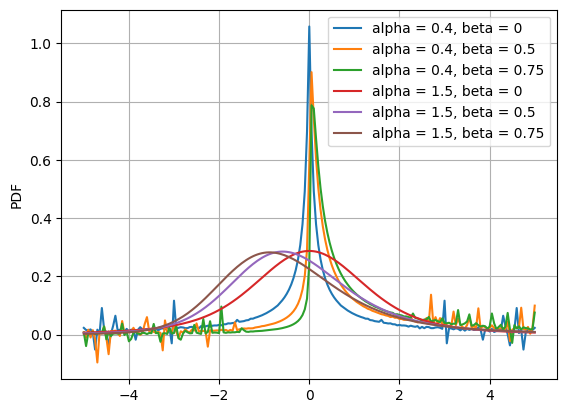

In [11]:
x_array = np.arange(-5,5.01,0.05)
for alpha in [0.4,1.5]:
    for beta in [0,0.5,0.75]:
        density = [p(x,alpha,beta,1,0) for x in x_array]
        plt.plot(x_array,density, label = f'alpha = {alpha}, beta = {beta}')
plt.ylabel('PDF')
plt.grid()
plt.legend()

***
**(c) Instead of our own implementation we can also use *scipy.stats.levy\_stable*. Plot the PDF using *scipy.stats.levy\_stable.pdf* with the same parameters as in (b). What do you observe?** 

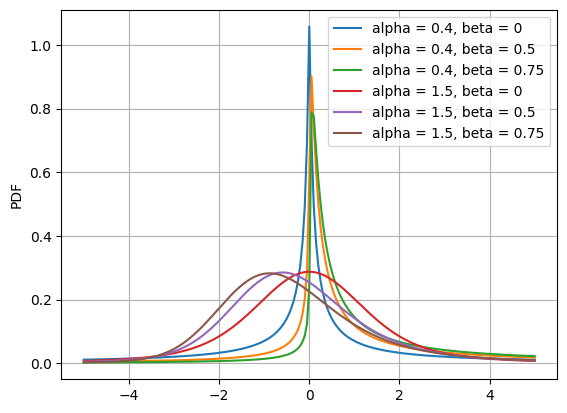

In [12]:
for alpha in [0.4,1.5]:
    for beta in [0,0.5,0.75]:
        plt.plot(x_array,sc.stats.levy_stable.pdf(x_array,alpha = alpha, beta = beta, loc = 0, scale = 1), label = f'alpha = {alpha}, beta = {beta}')
plt.ylabel('PDF')
plt.grid()
plt.legend()

We see that the results with *sc.stats.levy_stable.pdf* are smoother than the results from our function. Reasons can be the method of integration and stiffness of the ODE, for example.

***
**(d) In the following step we draw samples from the a stable distribution. Consider the parameters $\alpha = 0.5, \beta = 0.5, c = 1, mu = 0$. Draw 10000 realization from the distribution using *scipy.stats.levy\_stable.rvs*. In the next step, plot a histogram of the samples.**

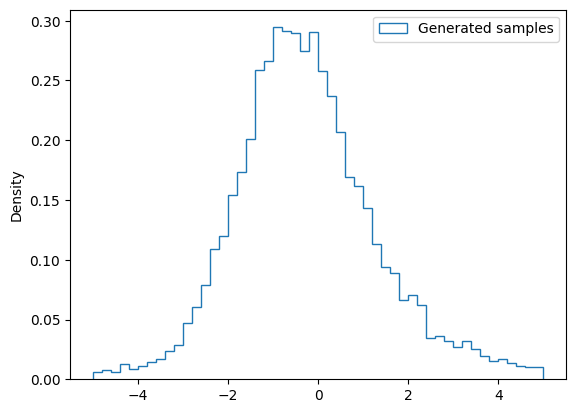

In [13]:
samples = sc.stats.levy_stable.rvs(alpha = 1.5, beta = 0.5, loc = 0, scale = 1, size = 10000)
plt.hist(samples, bins = 50, density = True, range=(-5,5), histtype='step', label = 'Generated samples')
plt.ylabel('Density')
plt.legend()
plt.show()

## Problem V.3 (PROGRAMMING) – Q-GAUSSIAN DISTRIBUTIONS AND PARAMETER FITTING

**We continue looking into non-Gaussian, i.e. q-Gaussian distributions. We consider a dataset of power grid frequency data with a 1-second time resolution, the dataset *frequency\_sample\_2015\_ex5.csv* can be found in [https://bwsyncandshare.kit.edu/s/QPySS7eZCWjSjYP](https://bwsyncandshare.kit.edu/s/QPySS7eZCWjSjYP).**

***
**(a) Plot a histogram of the data, both with linear and logarithmic scale on the y-axis, and calculate the kurtosis with *scipy.stats.kurtosis* (use *fisher=False*).**

The kusrtosis of the data distribution is: 3.950531486960724 
Note that the kurtosis of the normal/Gaussian distribution is 3.


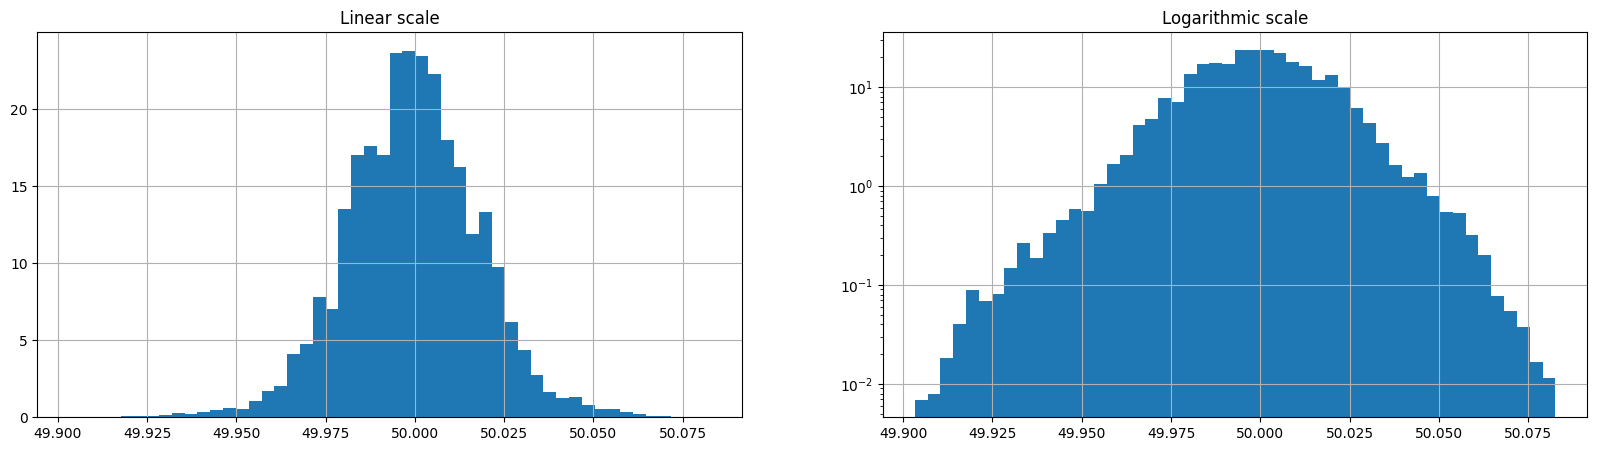

In [67]:
data = pd.read_csv('data/frequency_sample_2015_ex5.csv').values.reshape(-1)
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data, bins = 50, density = True)
ax[0].grid()
ax[0].set_title('Linear scale')

ax[1].hist(data, bins = 50, density = True)
ax[1].grid()
ax[1].set_title('Logarithmic scale')
ax[1].set_yscale('log')

print('The kusrtosis of the data distribution is:', sc.stats.kurtosis(data,fisher=False), '\nNote that the kurtosis of the normal/Gaussian distribution is 3.')

***
**(b) The probability density function of a q-Gaussian distribution is given as**

In [31]:
def q_Gauss_pdf(x,q,beta,mu):
    if q==1:
        constant = np.sqrt(np.pi)
    elif 1<q<3:
        constant=np.sqrt(np.pi)*gamma((3-q)/(2*(q-1)))/(np.sqrt(q-1)*gamma(1/(q-1)))
    else:
        constant = 2*np.sqrt(np.pi)*gamma(1/(1-q))/((3-q)*(1-q)*gamma((3-q)/(2*(1-q))))
    
    pdf=np.sqrt(beta)/constant*(1+(1-q)*(-beta*(x-mu)**2))**(1/(1-q))
    return pdf

'''We use beta > 0 in this definition'''

'We use beta > 0 in this definition'

**We assume beta > 0 in this definition.<br>
Now we aim to write a function for fitting the distribution, i.e. for a maximum log-likelihood estimation of the parameters $q$, with fixed $\beta$ and $\mu$, and initial parameter value for the maximization, $q_0$. Maximize the log-likelihood 
\begin{align*}\log(l_q(x_1,\ldots,x_n)) = \sum_{i=1}^n\log(p(x_i|q,\beta,mu))\end{align*}
with respect to $q$, where $x_i$ are the data points. For the optimization you can use *scipy.minimize*.**

In [34]:
def max_log_likelihood_q_gauss(data,beta,mu,q_0):
    def min_fun(par,beta=1,mu=0):
        q = par
        return -np.sum(np.log(q_Gauss_pdf(data,q,beta,mu)))
    # minimize the negative log likelihood
    # for details on the optimization method see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    result = sc.optimize.minimize(fun=min_fun, x0=[q_0],args=(beta,mu))
    q_result = result.x[0]
    return q_result

***
**(c) Normalize the frequency data by subtracting the mean and dividing by the standard deviation:**

In [35]:
data_normalized = (data-np.mean(data))/np.std(data)

**Fit the normalized frequency data with the following probability distributions:**
-  **Gaussian distribution $\rightarrow$ output: mean $\mu$ and variance $\sigma^2$,**
- **q-Gaussian distribution for fixed $\beta=1$, $\mu=0$ and initial parameter value $q_0=1.2$ $\rightarrow$ output: $q$.**

**For the normal distribution you can use *scipy.stats.norm.fit* and for the q-Gaussian distribution use your own function from (b).**

In [46]:
params_gauss = sc.stats.norm.fit(data_normalized)
print('The parameters (mean and standard deviation) for the Gaussian distribution, fitted to the normalized data, are: ',params_gauss[0], ' and ', params_gauss[1],'. \n(So exaclty as we assumed as we normalized the data, so we get the standard normal distribution.)')
param_q_gauss = max_log_likelihood_q_gauss(data_normalized, beta = 1, mu = 0, q_0 = 1.2)
print('\nThe parameter q for the q-Gaussian distribution, fitted to the normalized data, is: ',param_q_gauss)

The parameters (mean and standard deviation) for the Gaussian distribution, fitted to the normalized data, are:  -5.055605552067473e-13  and  1.0 . 
(So exaclty as we assumed as we normalized the data, so we get the standard normal distribution.)

The parameter q for the q-Gaussian distribution, fitted to the normalized data, is:  1.3400900441062569


***
**(d) Plot the resulting probability density functions (PDFs) in a figure together with the histogram of the normalized frequency data. Use a logarithmic scaling for the y-axis. Compare the result to the figure on slide 35 in the lecure 5.**

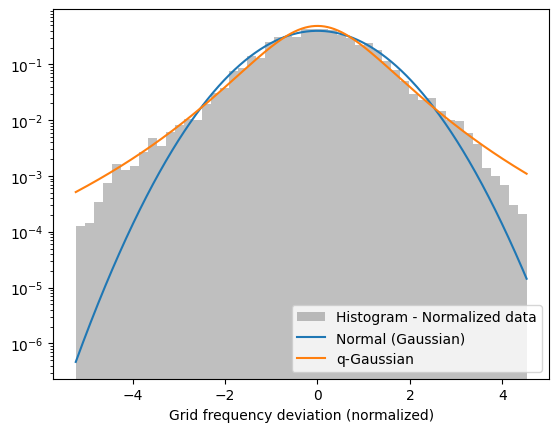

In [64]:
x = np.arange(np.min(data_normalized),np.max(data_normalized),0.01)
plt.hist(data_normalized, bins = 50, density = True, color='grey', alpha=0.5, label='Histogram - Normalized data')
plt.plot(x,sc.stats.norm.pdf(x,loc = params_gauss[0], scale = params_gauss[1]), label = 'Normal (Gaussian)')
plt.plot(x,q_Gauss_pdf(x,q=param_q_gauss,beta=1,mu=0), label = 'q-Gaussian')
plt.yscale('log')
plt.xlabel('Grid frequency deviation (normalized)')
plt.legend()

## Problem V.4 (programming) -- Superstatistics - Examples for a synthetic frequency dataset

**We consider the dataset *time\_series\_superstatistics.csv* which contains a time series consisting of several shorter time series linked together. The time series is constructed as follows:**

In [50]:
'''You don't need to tun the code! It is just for illustration purposes'''

damping=0.00211224
T= 20000 
logNormalFit=(0.5228696759042721, -6.139031040500482, 115.71274435712661)
#set some further parameters: Initial condition very close to zero and time resolution of the simulation
oneSecond=10
initialFrequency=10**-10
t = np.linspace(0, T, oneSecond*T+1)
delta_t = np.diff(t)[0]
#define the deterministic and the probabilistic contributions to the frequency dynamics
def bulkFrequency(y, t):
    omega = y
    dydt = -damping*omega
    return dydt

# define function for solving the stochastic differential equation 
def frequencyTrajectory(eps,initialFrequency):
    omega = np.zeros(len(t))
    omega[0]=initialFrequency
    dW = np.random.normal(0,1,len(t)) * np.sqrt(delta_t) # noise dynamics
    for i in range(1,len(t)):
        omega[i] = omega[i-1] - delta_t * damping*omega[i-1] + eps* dW[i] #  noise dynamics with noise amplitude epsilons
    sol = omega 
    return sol

'''An alternative method using the library sdeint for solving the stochastic differential equation would be:'''
# def frequencyTrajectory(eps,initialFrequency):
#     def noiseDynamicsDirect(x, t):
#         #define noise process
#         return eps
#     sol = sdeint.itoint(bulkFrequency,noiseDynamicsDirect, initialFrequency, t)
#     return sol.flatten()

#initialize list of frequency measurements
aggregatedTrajectory=[]
#draw several random realizations from the log-normal distribution to then use as noise amplitudes, similar to the Mathematica distribution, see also https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
numberOfGaussians = 500
randomBetas= sc.stats.lognorm(*logNormalFit).rvs(size=numberOfGaussians)
epsilons=np.sqrt(2*damping/randomBetas) # effective friction: randomBetas = 2*damping/epsilons^2 
#run process in series: to use previous end point of trajectory as new initial condition
for eps in epsilons:
    trajectory=frequencyTrajectory(eps,initialFrequency)
    initialFrequency=trajectory[-1]
    aggregatedTrajectory.append(trajectory[:-1])
#rescale to frequencies
frequency=(50+1/(2*np.pi)*np.array(aggregatedTrajectory).flatten())[0::oneSecond]

**The dynamics of the time series is given by a constant damping and a variable noise amplitude $\epsilon$ which is changing over time, i.e. each data snippet has a different noise amplitude. The "effective friction" $\beta = (2*damping)/ \epsilon^2$ is distributed with respect to a log-normal distribution.<br>
The list of "randomBetas" which was used for the construction of the time series can be found in *randomBetas.txt* in [https://bwsyncandshare.kit.edu/s/QPySS7eZCWjSjYP](https://bwsyncandshare.kit.edu/s/QPySS7eZCWjSjYP).**

***
**(a) Plot a histogram of the data, both with linear and logarithmic scale on the y-axis, and calculate the kurtosis with *scipy.stats.kurtosis* (use *fisher=False*).**

The kusrtosis of the frequency distribution is: 4.103658793529027


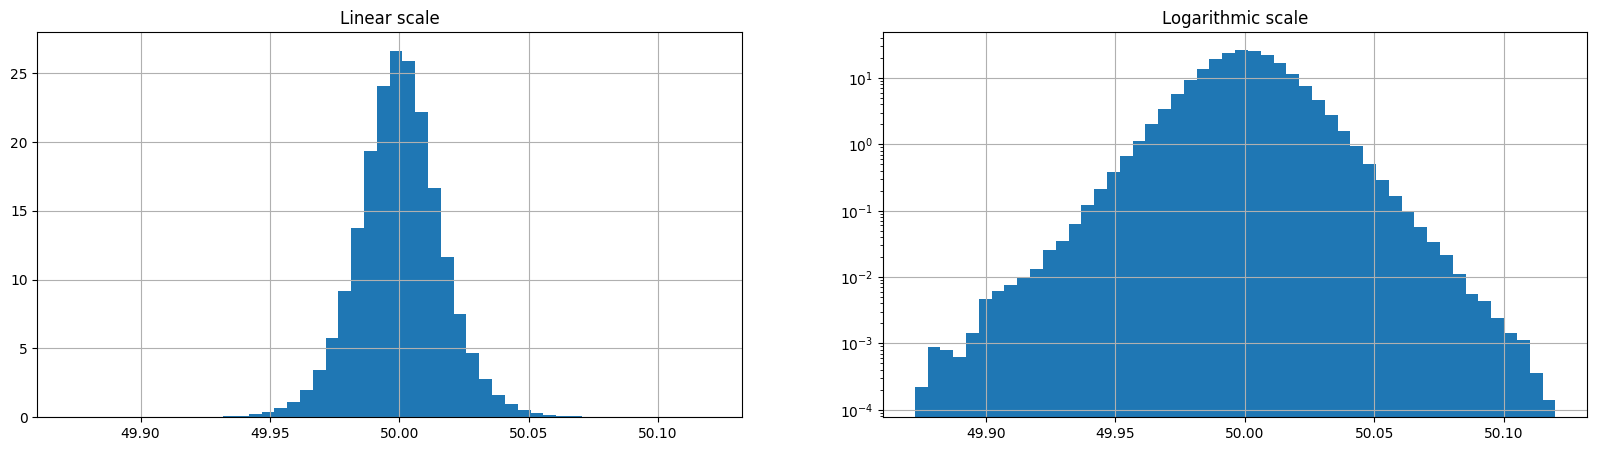

In [49]:
frequency = pd.read_csv('data/time_series_superstatistics.csv').values.reshape(-1)

fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].hist(frequency, bins = 50, density = True)
ax[0].grid()
ax[0].set_title('Linear scale')

ax[1].hist(frequency, bins = 50, density = True)
ax[1].grid()
ax[1].set_title('Logarithmic scale')
ax[1].set_yscale('log')

print('The kusrtosis of the frequency distribution is:', sc.stats.kurtosis(frequency,fisher=False))

***
**(b) We want to derive the superstatistics from the time series which is subject to the probability density function (PDF)
\begin{align*}
p(x)= \int_0^{\infty}f(\beta)p(x|\beta),
\end{align*} 
where $f(\beta)$ is the distribution of the effective friction $\beta$. For details, see slides 32 and 33 of lecture 5. <br>
At first we can derive the local kurtosis $\kappa(\Delta t)$ and the "long time scale" $T$, for which $\kappa(\Delta t = T) \approx 3$, i.e. the case for which a locally Gaussian kurtosis arises. <br>
The formula for the average kurtosis $\kappa(\Delta t)$ is given by**

In [50]:
def averageKappa(data,DeltaT):
    #make sure that negative calls return still a number
    if DeltaT<1:
        return 0
    meanData=np.mean(data); #here we use a global mean but a local mean for each data snippet of length DeltaT would also be ok. Results do not change too much
    tMax=len(data);
    nominator=sum((data[0:DeltaT]-meanData)**4)/DeltaT
    denominator=sum((data[0:DeltaT]-meanData)**2)/DeltaT
    sumOfFractions=nominator/(denominator**2);

    for i in range(0,tMax-DeltaT):
        nominator=nominator+((data[i+DeltaT]-meanData)**4-(data[i]-meanData)**4)/DeltaT;
        denominator=denominator+((data[i+DeltaT]-meanData)**2-(data[i]-meanData)**2)/DeltaT;
        sumOfFractions = sumOfFractions + nominator/(denominator**2);
    return sumOfFractions/(tMax-DeltaT) 

**Run *averageKappa(data=frequency, DeltaT = T)* with "long time scale $T=20000$. The output value should be $\approx 3$.**

In [51]:
averageKappa(frequency,DeltaT=20000)

3.062391046480211

***
**(c) Now complete in a similar way as the function *averageKappa* the following function for calculating the distribution of $\beta$, 
\begin{align*}\beta(t_0) = \frac{1}{<x^2>_{t_0,T}-<x>^2_{t_0,T}}\end{align*} 
for $t_0 = 0,\ldots,length(data)-T$, depending on the dataset and $T$:** 

In [52]:
def betaList(data,T):
    tMax=len(data)
    xSquareMean=sum(data[0:T]**2)/T # here: t_0 = 0
    xMean=sum(data[0:T])/T # here: t_0 = 0
    betaValues=[1/(xSquareMean-xMean**2)]
    # calculate the local averages for every t_0 = 1,...,tMax-T
    for i in range(0,tMax-T):
        # Complete the function simmilar as in the function "averageKappa":
        xSquareMean=xSquareMean+(data[i+T]**2-data[i]**2)/T;
        xMean=xMean+(data[i+T]-data[i])/T;
        betaValues.append(1/(xSquareMean-xMean**2))
    return np.array(betaValues) # this list contains lenth(data)-T+1 entries

**Note: We denote $<...>_{t_0,\Delta t} = \frac{1}{\Delta t}\int_{t_0}^{t_0+\Delta t}...~dt$ as local averages.**

***
**(d) Use your formula from (c) to calculate the values of  $\beta$ for $T=20000$ and for the dataset $data = (frequency-50) \cdot 2\pi$ (this represents the angulare velocity which is also used for the construction of the dataset), i.e. calculate 
\begin{align*}betaList\left(\text{data} = (frequency-50)\cdot 2\pi,\text{T} = 20000\right).\end{align*}  
<br>
    Then fit a log-normal distribution to the distribution, use *scipy.stats.lognorm.fit* in order to receive the parameters for the log-normal distribution.**

In [53]:
beta_list = betaList((frequency-50)*2*np.pi,20000)
# Now we fit log-normal distribution to the data and calculate the parameters
params_beta = sc.stats.lognorm.fit(beta_list)

***
**(e) Plot the following results in one figure:**
- **histogram of the output distribution from the *betaList*-function from (d),**
- **the probability density function given the parameters that were calculated in (d), use *scipy.stats.lognorm.pdf*,**
- **histogram of the randomBetas in *randomBetas.txt*.**

**Compare your result to the figure at the bottom in slide 36 of lecture 5.**

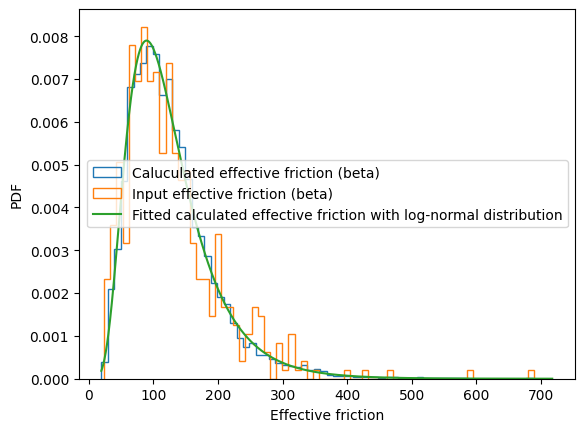

In [55]:
plt.hist(beta_list, bins = 70, density = True, histtype='step', label='Caluculated effective friction (beta)')
randomBetas = pd.read_csv('data/randomBetas.txt').values.reshape(-1)
plt.hist(randomBetas, bins = 70, histtype='step', density=True, label='Input effective friction (beta)')
x = np.arange(np.min(beta_list),np.max(beta_list),0.1)
plt.plot(x,sc.stats.lognorm.pdf(x, *params_beta), label = 'Fitted calculated effective friction with log-normal distribution')
plt.xlabel('Effective friction')
plt.ylabel('PDF')
plt.legend()

We see that the values for the effective friction (=beta) that we estimated from the data, has approximately the same distribution as the values for beta that we used for the construction of the data (see code above).

***
**(f) Normalize the time series as in Exercise 3. Fit the distribution of the normalized time series as in Exercise 3 with a normal distribution
    and a q-Gaussian distribution via the Maximum Likelihood method. <br>
For the normal distribution you can use *scipy.stats.norm.fit* 
    and for the q-Gaussian use your own function from Exercise V.3, using $\beta=1,\mu=0$ and $q_0=1.2$. Then plot the PDFs together with the histogram of the time series values. Use a logarithmic scaling for the y-axis.**

Normalize the frequency and fit the data with the distributions:

In [56]:
frequency_normalized = (frequency-np.mean(frequency))/np.std(frequency)
params_q_gauss = result_q_gauss = max_log_likelihood_q_gauss(frequency_normalized,1,0,1.2)
params_gauss = sc.stats.norm.fit(frequency_normalized)

Plot the histograms and the PDFs:

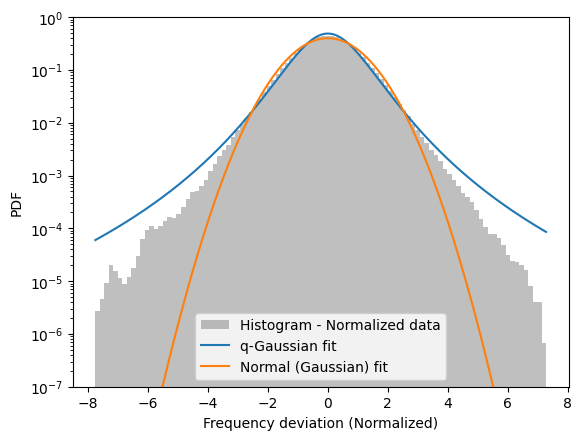

In [65]:
plt.hist(frequency_normalized, bins = 100, density = True, color='grey', alpha=0.5, label='Histogram - Normalized data')
x = np.arange(np.min(frequency_normalized),np.max(frequency_normalized),0.01)
plt.plot(x,q_Gauss_pdf(x,q=params_q_gauss,beta=1,mu=0), label = 'q-Gaussian fit')
plt.plot(x,sc.stats.norm.pdf(x,loc = params_gauss[0], scale = params_gauss[1]), label = 'Normal (Gaussian) fit')
plt.yscale('log')
plt.ylim(10**-7,10**0)
plt.ylabel('PDF')
plt.xlabel('Frequency deviation (Normalized)')
plt.legend()

We can observe that the distribution of the sxnthetic dataset that we constructed has quite large tails. We see that the q-Gaussian distribution yields a better fit for the tails of the distribution than the Gaussian distribution.